# Chapter 2 End to End ML Project

### California Housing Price Prediction

Business Objective - Predict the median prices of house beased on data for given districts. This is Supervised Multiple Regression task with Batch Learning for predicting univariate prediction (single value per district).


In [1]:
#Downloading the dataset

import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets","housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url = HOUSING_URL, housing_path= HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    

#Uncomment to download training dataset    
#fetch_housing_data()

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn as sns

In [3]:
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
    

In [4]:
#Load the dataset
housing = load_housing_data()

housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
print(housing.shape)

housing.info()

(20640, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Total districts are 20640 but only 20433 total_bedrooms are present in data.

Let's look at unique categories in ocean proximity

In [6]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Let's look at other fields

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


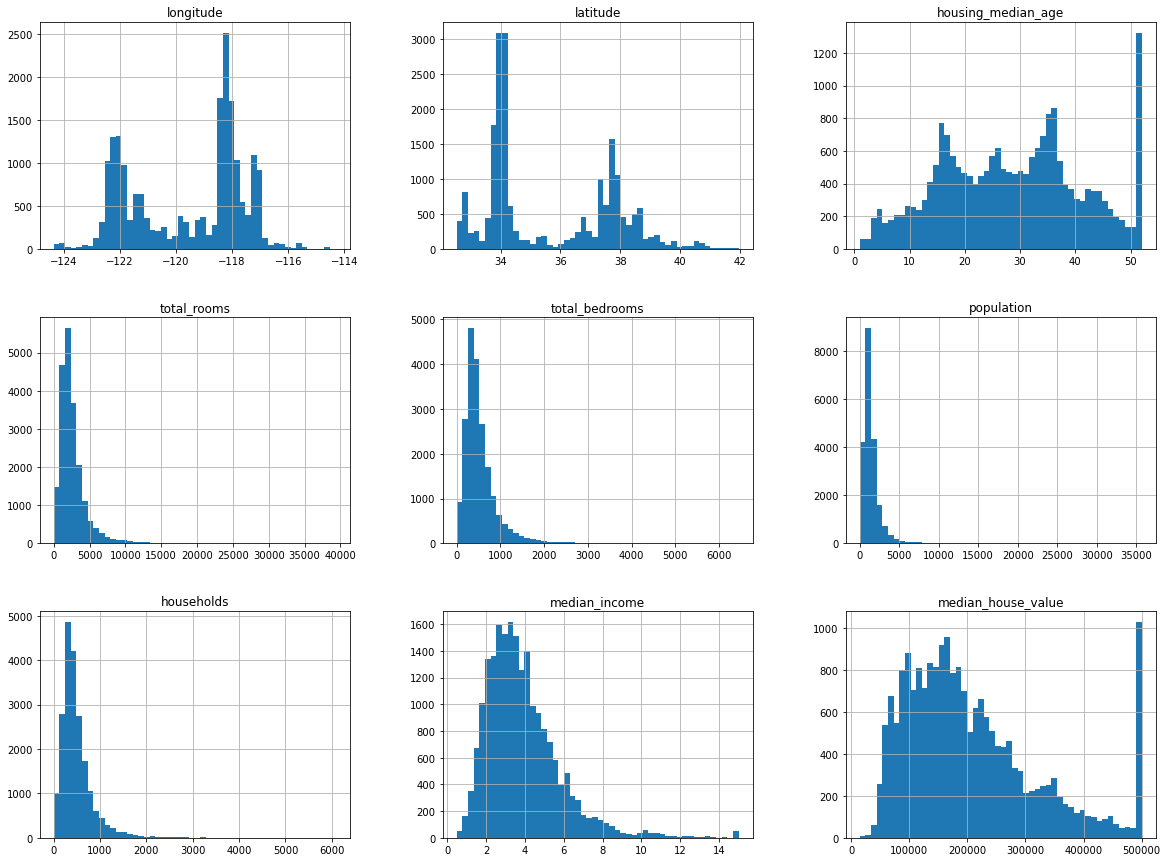

In [8]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

- Median income attribute has been scaled and capped to 15 (actually 15.0001) for higher median incomes and at 0.5 (actually 0.4999) for lower median incomes which represents roughly 10,000 dollars per unit.
- Housing median age and median house value were also capped. This may cause problems since ML algorithm may learn that prices never go beyond that limit. (Solution: Verify with clients, if they don't want cap, either collect fresh data for capped districts or remove capped districts for generalizing the predictions)
- Many histograms are tail heavy (right skewed - extend farther to the right of the median than to the left)

### Splitting data into Train and Test set

#### Random Sampling Methods
- If dataset is large enough (especially relative to number of attributes), this way of generating sets is fine. For smaller datasets, this may run the risk of introducing sampling bias.
- <b>Stratified Sampling: </b>Example if a company decides to call 1000 people for taking review, it won't pick 1000 people randomly. They will try to ensure that these 1000 people are representative of the whole population. Ex US population is comprised of 51.3% women and 48.7% men. So Comapny will try to maintain ratio in the sample as 513 women and 487 men. So pure random sampling here by 12% chance may cause skewed test set with either less than 49% female and more than 54% female, either way the survey would be significantly biased.


In [9]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[: test_set_size]
    train_indices = shuffled_indices[test_set_size : ]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = split_train_test(housing, 0.2)
print(f"Shapes -  train set: {train_set.shape} , test set: {test_set.shape}")

Shapes -  train set: (16512, 10) , test set: (4128, 10)


- We can populate training and test set by selecting index by random permutations but if we refresh importing dataset, we'll end up using some part of test dataset into training as well. 
- So one solution to this can be keep a fix np random state before calling np.random
But if the dataset was updated, this will also fail with the same problem.
- We can also hash each of the instance's identifier and put that instance in the test set if hash is lower or equal to 20% of maximum has value. This ensures test will remain consistent accross multiple runs even if we refresh dataset.
- The new test set will contain 20% of the new instances but it will not contain any instance that was previously in the training set.

In [11]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [12]:
#since housing dataset does not have identifier column, using row as index
housing_with_id = housing.reset_index() #adds an 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

print(f"Shapes -  train set: {train_set.shape} , test set: {test_set.shape}")

Shapes -  train set: (16512, 11) , test set: (4128, 11)


For using row as unique index, we need to make sure that new data gets appended at the end of the dataset and no row ever gets deleted.


Maybe instead of row we can also try most stable feature to build unqiue identifier
For example, a district's latiture and longitude are guranteed to be stable for few million years

In [13]:
housing_with_id["id"] = housing["longitude"]*1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

print(f"Shapes -  train set: {train_set.shape} , test set: {test_set.shape}")

Shapes -  train set: (16322, 12) , test set: (4318, 12)


Also sklearn provides train_test_split similar to split_train_test with some additional features like id and random state

In [14]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

print(f"Shapes -  train set: {train_set.shape} , test set: {test_set.shape}")

Shapes -  train set: (16512, 10) , test set: (4128, 10)


Suppose expert told us that median income is very important feature to predict median housing prices, then we may want to ensure that test set is representative of the various categories of incomes in the whole dataset.

Since median income is continuous numerical feature, we'll create income category attribute.
To do this let's look at the median income histogram more closely.

- Most median income values are clustered around 1.5 to 6 (i.e \\$15,000 to \\$60,000) but some median incomes go far beyond 6.
It is important to have sufficient instance in our dataset for each stratum or else the estimate of the stratum's importance may be biased. This means we should not have too many strata and each startum should be large enough.

Let's create income category attribute with 5 categories labelled from 1 to 5. Category 1 ranges from 0 to 1.5 (i.e. less than \\$15,000), category 2 from 1.5 to 3 and so on.

<AxesSubplot:>

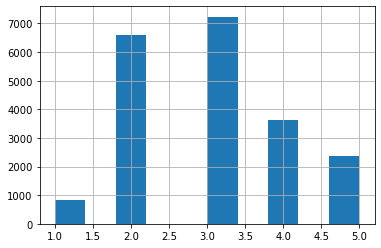

In [15]:
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1,2,3,4,5])

housing["income_cat"].hist()

#### Stratified Sampling
Now we are ready to do stratified sampling based on the income category. 

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    

In [17]:
#Let's check if this worked
print("Split after stratified sampling: ")
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

Split after stratified sampling: 


3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [18]:
#Splitting with random sampling for comapring income category proportions 
train_set , test_set = train_test_split(housing, test_size=0.2, random_state=42)

#Let's check if this worked
print("Split after random sampling: ")
test_set["income_cat"].value_counts()/len(test_set)

Split after random sampling: 


3    0.358527
2    0.324370
4    0.167393
5    0.109496
1    0.040213
Name: income_cat, dtype: float64

Let's compare income category proportions of overall dataset with in the test set generated with stratified sampling and random sampling

In [19]:
print("Comapring income category split while generating test dataset using Stratified Sampling vs Random Sampling")
pd.DataFrame([
housing["income_cat"].value_counts() / len(housing),
strat_test_set["income_cat"].value_counts()/len(strat_test_set),
test_set["income_cat"].value_counts()/len(test_set),
((housing["income_cat"].value_counts() / len(housing)  - test_set["income_cat"].value_counts()/len(test_set)) *100/ (housing["income_cat"].value_counts() / len(housing)) ),
((housing["income_cat"].value_counts() / len(housing)  - strat_test_set["income_cat"].value_counts()/len(strat_test_set)) *100/ (housing["income_cat"].value_counts() / len(housing)) )

], index=["Overall dataset", "Stratified Sampling", "Random Sampling", "% Error Random", "% Error Stratfied"])

Comapring income category split while generating test dataset using Stratified Sampling vs Random Sampling


,3,2,4,5,1
Overall dataset,0.350581,0.318847,0.176308,0.114438,0.039826
Stratified Sampling,0.350533,0.318798,0.176357,0.114583,0.039729
Random Sampling,0.358527,0.324370,0.167393,0.109496,0.040213
% Error Random,-2.266446,-1.732260,5.056334,4.318374,-0.973236
% Error Stratfied,0.013820,0.015195,-0.027480,-0.127011,0.243309


From above example we can see that test set generated using stratified sampling has income category proportions almost identical to those in the full dataset whereas in test generated by random sampling is quite skewed. 

In [20]:
#Removing income_cat feature since it's work is done
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis = 1, inplace = True)

### Exploring the data

In [21]:
#creating a copy of training set to play with the data
housing = strat_train_set.copy()

Text(0.5, 1.0, 'Geographical scatterplot of the data')

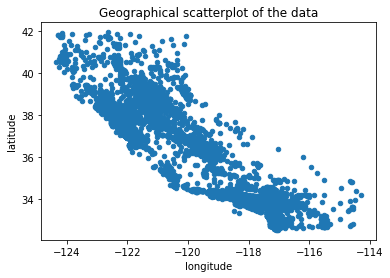

In [22]:
#visaulizing geographical data using scatterplot
housing.plot(kind = "scatter", x = "longitude", y="latitude")
plt.title("Geographical scatterplot of the data")

This looks like california but hard to see any perticular pattern. Setting alpha = 0.1 to visualize higher density of data points

Text(0.5, 1.0, 'Better Visualization highlighting high-density areas')

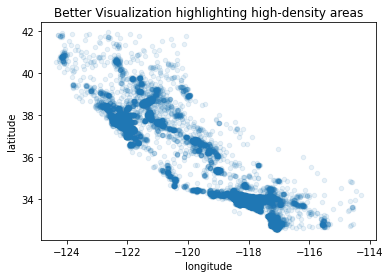

In [23]:
housing.plot(kind="scatter", x="longitude", y = "latitude", alpha=0.1)
plt.title("Better Visualization highlighting high-density areas")

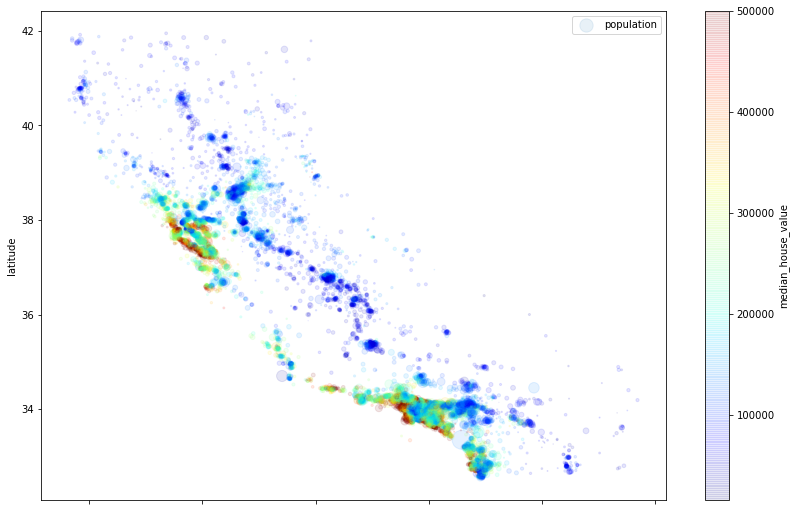

In [24]:
#Let's map housing prices to above visualization
#color map jet ranges from blue (low values) to red (high values)
housing.plot(kind="scatter", x="longitude", y="latitude", alpha = 0.1,
            s = housing["population"]/100, label="population", figsize=(14, 9),
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

plt.legend()

Above graph shows that housing prices are very much related to the location (e.g. close to the ocean) and population density. It will probably be useful for clustering algorithm to detect main clsuters and add new features that measure proximity to the cluster centers. Ocean proximity attribute may be useful as well but still may not be simple rule since housing prices in coastal districts are not too high.

In [25]:
#Let's compute standard correlation coefficient (Pearson's Correlation coeffient)
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

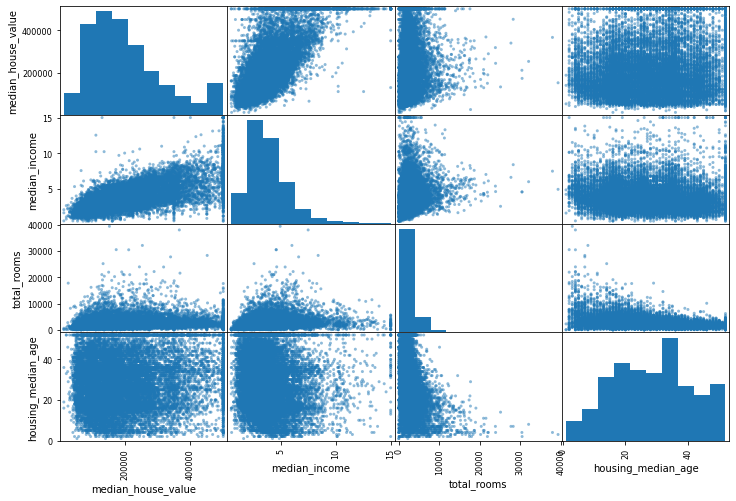

In [27]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value","median_income","total_rooms","housing_median_age"]

scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

Most promising attribute to predict median_house_value seems to be median_income so let's zoom into their correlation scatterplot

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

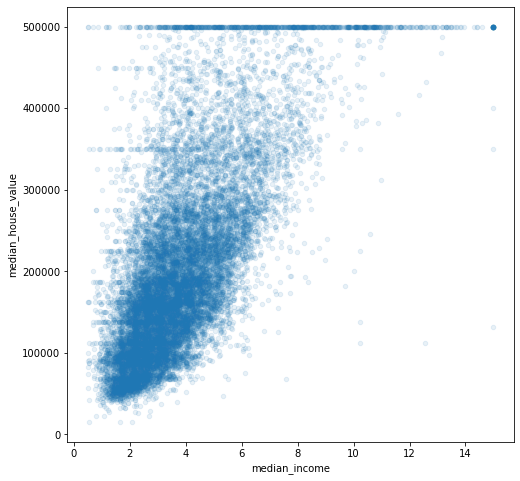

In [29]:
housing.plot(kind='scatter', x="median_income", y="median_house_value", alpha=0.1, figsize=(8,8))

This reveals few things,
- Correlation is indeed very strong, we can clearly see upward trend and points are not too dispersed.
- Price cap is also clearly visible as horizontal line at \\$5,00,000.
- But it also reveals other obvious straight lines , a horizontal line around \\$4,50,000 and another around \\$3,50,000 and between \\$2,00,000 to \\$3,00,000
We may want to try removing the corrosponding districts to prevent the algorithms from learning to reproduce these data quirks

### Experimenting with Attribute Combinations

So now we may want to clean up the data before feeding it to ML algorithm.
We also noticed that some attributes are tail heavy distributed so we may want to transform them (e.g. by computing logarithm). 
Also before preparing ML data, we may want to try various attribute combinations, ex total number of rooms in districts is not very usefil if you don't know how many households are there. What we really want is the number of room per household. 
Similarly total number of bedrooms by itself is not useful, so we may want to compare it to the number of rooms and population per household also seems like an interesting attribute combination to look at.

In [31]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [32]:
corr_matrix = housing.corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

The new bedroom_per_room attribute is much more correlated with the median house value than total number of rooms or bedrooms.
The number of rooms per household is also more informative than total number of rooms in a district.

### Prepare the data for Machine Learning

In [34]:
#Let's revert to the clean data
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

### Data Cleaning
Let's handle missing values in total_bedrooms attribute. We have 3 options
- Get rid of corrosponding districts
- Get rid of whole attribute
- Set the values to some value - <b>Currently selecting median</b>

In [36]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
print(imputer.statistics_)

X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


### Handeling the categorical variable

In [37]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.value_counts()

ocean_proximity
<1H OCEAN          7276
INLAND             5263
NEAR OCEAN         2124
NEAR BAY           1847
ISLAND                2
dtype: int64

In [38]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

ordinal_encoder.fit(housing_cat)
print(ordinal_encoder.categories_)

housing_cat_encoded = ordinal_encoder.transform(housing_cat)

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


In [39]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
cat_encoder.fit(housing_cat)

print(cat_encoder.categories_)
housing_cat_1hot = cat_encoder.transform(housing_cat)

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


In [42]:
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

### Sample scikitlearn compatible custom tranformer 

In [43]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): #no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self  #nothing else to do
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In this example, transformer has one hyperparameter, add_bedrooms_per_room. This hyperparameter will help us to easily find out if adding this attribute helps our Machine Learning algorithm or not. 

### Feature Scaling
Note: Scaling of the target attribute is generally not required
- Normalization - Scale between 0-1 by default
- Standardization - Scale with zero mean and unit variance. Since it does not bound to specific range which might be problematic for some algorithms like neural nets but it is less affected by outliers,  

#### Pipeline
- Pipeline takes name/estimator pairs defining sequence of steps.  all but last estimator must be transformers (i.e. they must have a fit_transform() method)
- Names will come in handy for hyperparamter tuning and they can be anything
- Pipeline exposes the same methods as the final estimator.

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

It is more convenient to have a single Transformer able to handle all columns, applying appropriate column tranformations to each column.
Here each tuple in the pipeline list contains,
- Name
- Transformer
- List of names / indices that the transformer should be applied to


<b>Note: </b> 
 1. The OneHotEncoder returns a sparse matrix while num_pipeline returns a dense matrix. When there is such a mix of sparse and dense matrix, the ColumnTransformer estimates density of the final matrix (i.e. ratio of non-zero cells) and it returns sparse matrix if the density is lower than given threshold (by default sparse_threshold=0.3). In this example it returns dense matrix.
 2. Instead of Transformer we can specify string "drop" if we want the columns to be dropped or specify "passthrough" if the columns needs to be left untouched.
 3. By Default the remaining columns (i.e. the ones not listed) will be dropped. We can also set remainder hyperparameter to any transformer (or to "passthrough") if we want these columns to be handled differently

In [49]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = list(housing_cat)

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

### Select and Train Model

In [54]:
#Base model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

some_data_prepared = full_pipeline.transform(some_data)
print("Predictions: ", lin_reg.predict(some_data_prepared))

Predictions:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [56]:
#Evaluating model
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(some_data_prepared)
lin_mse = mean_squared_error(some_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

46578.63831786745

Since median_housing_values range between \\$1,20,000 and \\$2,65,000 this is not a great score. This may be underfitted model.

In [57]:
#A bit more powerful model
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(some_data_prepared)
tree_mse = mean_squared_error(some_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

It is much more likely that this model is overfitted. We can be more sure after validating this with test set. But we don't want to touch test_set till we are confidant to luanch a model

### Better Evaluation using Cross Validation
<b>Note: </b>Scikitlearn's cross validation feature expect a utility function (greater is better) than cost function (lower is better). Which is why below code computes -scores before calculating sqrt

In [59]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [60]:
def display_scores(scores):
    print("scores: ",scores)
    print("mean score: ", scores.mean())
    print("Standard Deviation: ", scores.std())

In [61]:
display_scores(tree_rmse_scores)

scores:  [68323.91113191 67539.5023031  71407.74909577 67312.22789918
 69704.30257349 74807.62882722 70473.86268529 71628.03064018
 76258.89255875 69775.85081558]
mean score:  70723.19585304723
Standard Deviation:  2795.3321307354836


Now the Decision Tree doesn't look so good as it did earlier. In fact it seems to perform worse than Linear Regression
Cross validation allows us to get estimate of the performance of the model and measurement of how precise it is (standard deviation)

In [62]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error",cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
mean score:  69052.46136345083
Standard Deviation:  2731.674001798345


In [63]:
#Trying Random forest regression
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg.fit(housing_prepared, housing_labels)

rf_scores = cross_val_score(rf_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
rf_rmse_scores = np.sqrt(-rf_scores)
display_scores(rf_rmse_scores)

scores:  [49316.9779096  47868.96620979 50040.22364413 52330.70897033
 49762.50648088 53326.51471481 48963.42053404 47789.65932935
 52993.88543587 50399.68252466]
mean score:  50279.25457534676
Standard Deviation:  1893.8615992491643


In [66]:
housing_predictions = rf_reg.predict(housing_prepared)
rf_mse = mean_squared_error(housing_labels, housing_predictions)
rf_rmse = np.sqrt(tree_mse)
rf_rmse

0.0

CV results of Random forest looks promising but scores on training set is still showing signs of overfitting.

### Fine tune model
#### Grid Search
- Param grid tells scikit learn to first evaluate all 3x4 - 12 combinations of n_estimators and max_features hyperparameter values specified in first dict. Then try all 2x3  = 6 combinations of hyperparameter values in second dict but this time with bootstrap hyperparameter set to False (default was True).
- All in all, grid search will explore 12 + 6 = 18 combinations of RandomForestRegressor and will train each model five times (since we are using 5 fold cross validation). So all in all there will be 18 * 5 = 90 rounds of training!

In [67]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3,10,30], 'max_features':[2,4,6,8]},
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features':[2,3,4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [68]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [69]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [74]:
cvres = grid_search.cv_results_
for mean_score,params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

63650.45034011449 {'max_features': 2, 'n_estimators': 3}
55375.242532175034 {'max_features': 2, 'n_estimators': 10}
52865.844818595346 {'max_features': 2, 'n_estimators': 30}
60499.47165206298 {'max_features': 4, 'n_estimators': 3}
52929.86422017255 {'max_features': 4, 'n_estimators': 10}
50521.21141713497 {'max_features': 4, 'n_estimators': 30}
58959.141023364085 {'max_features': 6, 'n_estimators': 3}
51985.199504375596 {'max_features': 6, 'n_estimators': 10}
50150.46760567937 {'max_features': 6, 'n_estimators': 30}
58723.06232696792 {'max_features': 8, 'n_estimators': 3}
52557.467532996816 {'max_features': 8, 'n_estimators': 10}
49920.455477141426 {'max_features': 8, 'n_estimators': 30}
62255.43862014857 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54995.40152672781 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59848.248570303185 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52659.052823474434 {'bootstrap': False, 'max_features': 3, 'n_estimat

#### Randomized Search
Gridsearch approach is good when we are exploring very few combinations like earlier example. But when the hyperparamter seach space is large, mostly RandomizedSearchCV is used instead. This instead of trying out all possible combinations, it evaluates given number of random combinations by selecting random value for each hyperparameter at every iteration.  

### Analyzing best models and their Errors

In [75]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.46499954e-02, 5.84845035e-02, 4.22517669e-02, 1.63343795e-02,
       1.47773553e-02, 1.51074004e-02, 1.50962146e-02, 3.74202770e-01,
       4.38901033e-02, 1.12128257e-01, 5.59675015e-02, 1.96306087e-03,
       1.80486302e-01, 5.81036914e-05, 1.58457058e-03, 3.01771625e-03])

In [76]:
#Displaying importance scores with corrosponding attribute names
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse=True)

[(0.3742027698063368, 'median_income'),
 (0.18048630187359738, 'INLAND'),
 (0.1121282565346565, 'pop_per_hhold'),
 (0.06464999538613207, 'longitude'),
 (0.05848450350741024, 'latitude'),
 (0.05596750148278112, 'bedrooms_per_room'),
 (0.043890103280881824, 'rooms_per_hhold'),
 (0.042251766870240896, 'housing_median_age'),
 (0.01633437953796834, 'total_rooms'),
 (0.015107400399127705, 'population'),
 (0.015096214635367236, 'households'),
 (0.014777355297507507, 'total_bedrooms'),
 (0.0030177162479950925, 'NEAR OCEAN'),
 (0.0019630608698516403, '<1H OCEAN'),
 (0.0015845705787823601, 'NEAR BAY'),
 (5.810369136336879e-05, 'ISLAND')]

With this information, we may want to try dropping some of the less useful features. Ex. apprantly only one ocean_proximity category is really useful so we could try dropping others

### Evaluating final system on the Test set

In [77]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_preapred = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_preapred)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48635.15736648863

In some cases such point estimate of the generalization error will not be quite enough to convince this model to launch. We need an idea how precise this estimate is.

In [79]:
#let's compute 95% confidance interval

from scipy import stats
confidance = 0.95

squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidance, len(squared_errors) -1, loc=squared_errors.mean(), scale = stats.sem(squared_errors)))

array([46648.47355592, 50543.81247026])

The performance will usually be slightly worse than what we measured using cross validation if we did a lot of hyperparameter tuning.